# Regression model

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataAir = 'aqi_yearly_1980_to_2021.csv'
usecols = ['State', 'County', 'Year', 'Days with AQI', 'Good Days', 'Moderate Days', 
           'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days',
           'Median AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days SO2',
           'Days PM2.5', 'Days PM10', 'Latitude', 'Longitude']
dfAir = pd.read_csv(dataAir, usecols=usecols)#, usecols=usecols

dfAir = dfAir[(dfAir['Year']==2016)]
del dfAir['Year']

print(len(dfAir))
print(list(dfAir.columns))

1003
['State', 'County', 'Days with AQI', 'Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Median AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10', 'Latitude', 'Longitude']


In [3]:
dfAir.columns = dfAir.columns.str.lower().str.replace(' ', '_')
strings = list(dfAir.dtypes[dfAir.dtypes == 'object'].index)
for col in strings:
    dfAir[col] = dfAir[col].str.lower().str.strip().str.replace(' ', '_')

#print(dfAir['year'].unique())
#print(dfAir['county'].unique())
#dfAir.T
dfAir.head(2)

,state,county,days_with_aqi,good_days,moderate_days,unhealthy_for_sensitive_groups_days,unhealthy_days,very_unhealthy_days,hazardous_days,median_aqi,days_co,days_no2,days_ozone,days_so2,days_pm2.5,days_pm10,latitude,longitude
29070,alabama,baldwin,279,247,32,0,0,0,0,37,0,0,221,0,58,0,30.497478,-87.880258
29071,alabama,clay,116,109,7,0,0,0,0,30,0,0,0,0,116,0,33.284928,-85.803608


In [4]:
usecols = ['StateDesc', 'CountyName', 'TotalPopulation', 'CASTHMA_AdjPrev']
dataAsthma = 'PLACES_County_Data.csv'
dfAsthma = pd.read_csv(dataAsthma, usecols=usecols)
print(len(dfAsthma))

3142


In [5]:
dfAsthma.columns = dfAsthma.columns.str.lower().str.replace(' ', '_')
strings = list(dfAsthma.dtypes[dfAsthma.dtypes == 'object'].index)
for col in strings:
    dfAsthma[col] = dfAsthma[col].str.lower().str.replace(' ', '_')
dfAsthma = dfAsthma.rename(columns={"countyname": "county", "statedesc": "state"})

In [6]:
df = pd.merge(dfAir, dfAsthma, left_on=['state','county'], right_on = ['state','county'], how='inner')

In [7]:
df.head(2)

,state,county,days_with_aqi,good_days,moderate_days,unhealthy_for_sensitive_groups_days,unhealthy_days,very_unhealthy_days,hazardous_days,median_aqi,days_co,days_no2,days_ozone,days_so2,days_pm2.5,days_pm10,latitude,longitude,totalpopulation,casthma_adjprev
0,alabama,baldwin,279,247,32,0,0,0,0,37,0,0,221,0,58,0,30.497478,-87.880258,218022,9.6
1,alabama,clay,116,109,7,0,0,0,0,30,0,0,0,0,116,0,33.284928,-85.803608,13275,11.1


In [8]:
print(len(df))

972


<AxesSubplot:xlabel='casthma_adjprev', ylabel='Density'>

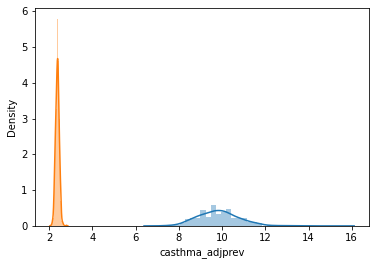

In [10]:
sns.distplot(df.casthma_adjprev)
sns.distplot(np.log1p(df.casthma_adjprev))

In [11]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.casthma_adjprev.values)
y_val = np.log1p(df_val.casthma_adjprev.values)
y_test = np.log1p(df_test.casthma_adjprev.values)

del df_train['casthma_adjprev']
del df_val['casthma_adjprev']
del df_test['casthma_adjprev']

print(len(df_train))

582


In [31]:
data_numeric = df_full_train.copy()
data_numeric = df_full_train.drop(["state","county"], axis=1)
data_numeric.describe()

,days_with_aqi,good_days,moderate_days,unhealthy_for_sensitive_groups_days,unhealthy_days,very_unhealthy_days,hazardous_days,median_aqi,days_co,days_no2,days_ozone,days_so2,days_pm2.5,days_pm10,latitude,longitude,totalpopulation,casthma_adjprev
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,7.770000e+02,777.000000
mean,319.895753,262.110682,53.247104,3.760618,0.711712,0.021879,0.043758,35.558559,0.069498,4.555985,181.598456,8.489060,113.033462,12.149292,38.960439,-93.421828,2.738452e+05,9.834492
std,81.467473,77.268181,43.634591,10.521179,6.931869,0.228814,0.875285,11.453603,1.238476,16.547410,121.105213,41.292865,109.428819,51.347571,5.397899,16.224807,5.976001e+05,0.942329
min,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.555444,-160.508331,7.200000e+02,7.400000
25%,329.000000,215.000000,22.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,0.000000,104.000000,0.000000,3.000000,0.000000,35.587144,-105.245040,3.645900e+04,9.200000
50%,363.000000,286.000000,42.000000,1.000000,0.000000,0.000000,0.000000,37.000000,0.000000,0.000000,196.000000,0.000000,98.000000,0.000000,39.472471,-88.372510,1.027930e+05,9.800000
75%,366.000000,321.000000,74.000000,4.000000,0.000000,0.000000,0.000000,41.000000,0.000000,0.000000,270.000000,0.000000,178.000000,0.000000,42.298493,-81.606833,2.698050e+05,10.400000
max,366.000000,366.000000,270.000000,128.000000,181.000000,4.000000,24.000000,151.000000,34.000000,183.000000,366.000000,366.000000,366.000000,366.000000,64.839846,-67.265408,1.010552e+07,15.400000


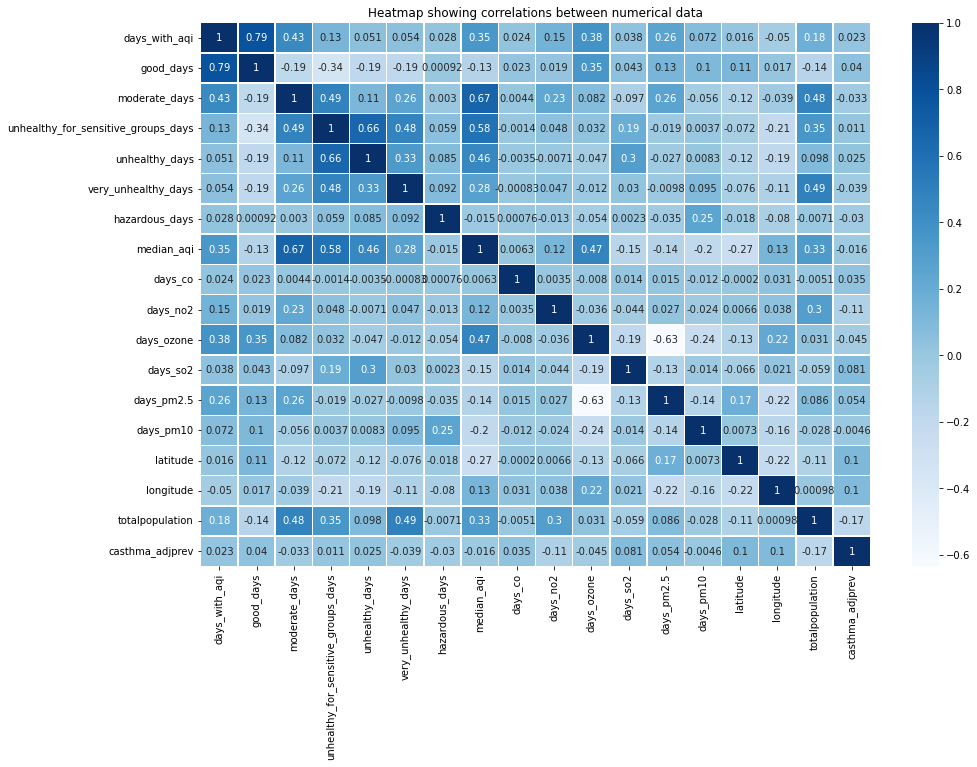

In [32]:
plt.figure(figsize=(15,10))  
sns.heatmap(data_numeric.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [36]:
data_numeric.corr().unstack().sort_values(ascending = False).head(50)

casthma_adjprev                      casthma_adjprev                        1.000000
days_co                              days_co                                1.000000
latitude                             latitude                               1.000000
days_pm10                            days_pm10                              1.000000
days_pm2.5                           days_pm2.5                             1.000000
days_so2                             days_so2                               1.000000
days_ozone                           days_ozone                             1.000000
days_no2                             days_no2                               1.000000
median_aqi                           median_aqi                             1.000000
totalpopulation                      totalpopulation                        1.000000
hazardous_days                       hazardous_days                         1.000000
very_unhealthy_days                  very_unhealthy_days         

In [25]:
pd.cut(np.log1p(df_full_train.casthma_adjprev), bins=10).value_counts()

(2.329, 2.396]    225
(2.396, 2.463]    209
(2.262, 2.329]    131
(2.463, 2.53]      98
(2.195, 2.262]     72
(2.53, 2.597]      26
(2.128, 2.195]     11
(2.597, 2.663]      3
(2.73, 2.797]       1
(2.663, 2.73]       1
Name: casthma_adjprev, dtype: int64

In [30]:
qcasthma = pd.qcut(df_full_train.casthma_adjprev, q=10)
from sklearn.metrics import normalized_mutual_info_score
print('Correlation between County and asthma:', normalized_mutual_info_score(df_full_train.county, qcasthma))
print('Correlation between  State and asthma:', normalized_mutual_info_score(df_full_train.state, qcasthma))

Correlation between County and asthma: 0.4575732267425729
Correlation between  State and asthma: 0.22507445192860256


In [14]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [16]:
from sklearn.linear_model import Lasso
for a in [0, 0.001, 0.01, 0.1, 2, 3, 4]:
    lr = Lasso(alpha=a)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print('a: ', a, 'score: ', score)
#2017 a:  0.001 score:  0.0742091332330527
#2016 a:  0.001 score:  0.06972316416639601
#2015 a:  0.001 score:  0.07581399693639637

a:  0 score:  0.13687351242950788
a:  0.001 score:  0.06972316416639601
a:  0.01 score:  0.08146370866097395
a:  0.1 score:  0.08189382450392586
a:  2 score:  0.08218608659756435
a:  3 score:  0.08218624576615575
a:  4 score:  0.08218640494565965


In [17]:
from sklearn.linear_model import Ridge
for a in [0.001, 0.01, 0.1, 2, 3, 3.5, 4, 10]:
    model = Ridge(alpha=a,random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print('a: ', a, 'score: ', score)
#2017 a:  3 score:  0.06646176277140042
#2016 a:  3 score:  0.06798535348388787
#2015 a:  3 score:  0.06556374731153568

a:  0.001 score:  0.19670207397435527
a:  0.01 score:  0.09387713002062435
a:  0.1 score:  0.07623854967657456
a:  2 score:  0.06826597834762965
a:  3 score:  0.06798535348388787
a:  3.5 score:  0.068034387417815
a:  4 score:  0.06816106727931154
a:  10 score:  0.07156872050262131


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))
#2017 - 0.07674271714140564
#2016 - 0.07453489708788917
#2015 - 0.07792719460444107

0.06707276897607575

In [19]:
test_dicts = df_test.iloc[6].to_dict()
X_test = dv.transform(test_dicts)
y_pred = dt.predict(X_test)
print(np.expm1(y_pred))
print(np.expm1(y_test[6]))

[9.68898781]
10.1


In [20]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- latitude <= 30.63
|   |--- totalpopulation <= 350077.50
|   |   |--- latitude <= 29.62
|   |   |   |--- unhealthy_for_sensitive_groups_days <= 0.50
|   |   |   |   |--- days_with_aqi <= 358.50
|   |   |   |   |   |--- good_days <= 336.00
|   |   |   |   |   |   |--- value: [2.28]
|   |   |   |   |   |--- good_days >  336.00
|   |   |   |   |   |   |--- value: [2.33]
|   |   |   |   |--- days_with_aqi >  358.50
|   |   |   |   |   |--- state=texas <= 0.50
|   |   |   |   |   |   |--- value: [2.22]
|   |   |   |   |   |--- state=texas >  0.50
|   |   |   |   |   |   |--- totalpopulation <= 142588.50
|   |   |   |   |   |   |   |--- value: [2.24]
|   |   |   |   |   |   |--- totalpopulation >  142588.50
|   |   |   |   |   |   |   |--- value: [2.26]
|   |   |   |--- unhealthy_for_sensitive_groups_days >  0.50
|   |   |   |   |--- latitude <= 29.41
|   |   |   |   |   |--- days_pm10 <= 0.50
|   |   |   |   |   |   |--- longitude <= -119.40
|   |   |   |   |   |   |   |--- value: [2.35

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))
#2017 0.06595664875495226
#2016 0.061032565374865906
#2015 0.062477446785953

0.061032565374865906

In [22]:
county = df_test.iloc[20].to_dict()
county

{'state': 'nevada',
 'county': 'clark',
 'days_with_aqi': 366,
 'good_days': 125,
 'moderate_days': 215,
 'unhealthy_for_sensitive_groups_days': 25,
 'unhealthy_days': 0,
 'very_unhealthy_days': 1,
 'hazardous_days': 0,
 'median_aqi': 58,
 'days_co': 0,
 'days_no2': 27,
 'days_ozone': 219,
 'days_so2': 0,
 'days_pm2.5': 114,
 'days_pm10': 6,
 'latitude': 36.569333,
 'longitude': -115.676651,
 'totalpopulation': 2231647}

In [23]:
df_small = pd.DataFrame([county])
df_small

,state,county,days_with_aqi,good_days,moderate_days,unhealthy_for_sensitive_groups_days,unhealthy_days,very_unhealthy_days,hazardous_days,median_aqi,days_co,days_no2,days_ozone,days_so2,days_pm2.5,days_pm10,latitude,longitude,totalpopulation
0,nevada,clark,366,125,215,25,0,1,0,58,0,27,219,0,114,6,36.569333,-115.676651,2231647


In [24]:
test_dicts = df_test.iloc[6].to_dict()
X_test = dv.transform(test_dicts)
y_pred = rf.predict(X_test)
print(np.expm1(y_pred))
print(np.expm1(y_test[6]))

[10.01026235]
10.1
